In [17]:
import re
import sys
import numpy as np
from collections import defaultdict
import os
def parse_train_log_file(log_file_path):
    # Regular expression to match lines containing epoch information
    epoch_time_pattern = r'Epoch (\d+), Loss: [\d.]+, Time: ([\d.]+) seconds'
    epoch_times = {}

    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.match(epoch_time_pattern, line)
            if match:
                epoch_number = int(match.group(1))
                epoch_time = float(match.group(2))
                epoch_times[epoch_number] = epoch_time
        #print(f"Average Training Time of {log_file_path}: {np.mean(list(epoch_times.values())):.2f} seconds")
        #print(f"Sum Training Time of {log_file_path}: {np.sum(list(epoch_times.values())):.2f} seconds")
    return np.sum(list(epoch_times.values()))
parse_train_log_file('/home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_betrain/RUN1/LS30/imgclassification/mobilenet/BE_imgclassification_MPS70.log')

463.9

In [18]:
# parse inference log file
import re

def parse_inference_log_file(log_file_path):
    # Regular expressions to extract processing times
    avg_time_pattern = re.compile(r"Average processing time: (\d+\.\d+) seconds")
    total_time_pattern = re.compile(r"Total processing time: (\d+\.\d+) seconds")

    # Initialize variables to store processing times
    avg_processing_time = None
    total_processing_time = None

    # Open the log file and read its content
    with open(log_file_path, 'r') as file:
        log_content = file.read()

        # Search for average processing time
        avg_match = avg_time_pattern.search(log_content)
        if avg_match:
            avg_processing_time = float(avg_match.group(1))

        # Search for total processing time
        total_match = total_time_pattern.search(log_content)
        if total_match:
            total_processing_time = float(total_match.group(1))

    return total_processing_time

# Example usage
log_file_path = "/home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_beinf/mobilenetv2_vit_resnet_wav2vec/RUN1/LS10/speech-recognition/facebook/wav2vec2-base-960h/facebook/wav2vec2-base-960h/batch1.log"
total_time = parse_inference_log_file(log_file_path)
#print("Average processing time:", avg_time, "seconds")
print("Total processing time:", total_time, "seconds")

Total processing time: 102.5394 seconds


In [19]:



def get_subdirectories(root_dir, type):
    all_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if type in filename:
                file_path = os.path.join(dirpath, filename)
                all_files.append(os.path.join(dirpath, filename))
            
                #print(file_path)

    return all_files

# Example usage:
root_directory = '/home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_betrain/RUN1'
#get_subdirectories(root_directory, "LSmetrics")


In [20]:
#functions for parsing logs and writing to CSV
def parse_all_BE_logs(root_directory, models, LS_percents, type, baseline):
    #init throughput dict
    throughput_dict = defaultdict(dict)
    for model in models:
        throughput_dict[model] = {}
        for percent in LS_percents:
            throughput_dict[model][f"{percent}"] = []
        throughput_dict[model]["baseline"] = []

    #choose parse log based on types
    parse_logs = parse_train_log_file if type == "training" else parse_inference_log_file
    for root_dir in root_directory:
        for model in models:
            for percent in LS_percents:
                for file in get_subdirectories(root_dir, "BE"):
                    if f"{percent}/" in file and model in file:#percent add / to avoid LS100 identified as LS10
                        throughput_dict[model][f"{percent}"].append(parse_logs(file))
                        
    #add train baseline to throughput dict
    for model in models:
        throughput_dict[model]["baseline"].append(baseline[type][model])
    #print(throughput_dict)
    return throughput_dict
#write throughput dict to csv
import csv
def write_BE(filename, data, models, cols):
    #print(filename)
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(cols)
        for model in models:
            print(model, data[model].keys() )
            row = [model]
            for k, v in data[model].items():
                row.append(np.mean(v))#average of each run
            #row.append(np.mean(data[model]["baseline"]))
            writer.writerow(row)

In [21]:
#add baseline
baseline_0301 = {
                    "training" : 
                    {"resnet" : 511, "mobilenet" : 445, "bert-base" : 255, "microsoft/toyCNN" : 334.32},
                    "inference":
                    {"microsoft/resnet" : 97.2, "google/mobilenet" : 88.36, "google/vit-base" : 105, "facebook/wav2vec" : 94.2,
                     "bert-base-cased": 323, 'openai/whisper-large-v2': 662},
                    "LS_lambda0.05": 
                    {"generation_throughput": 29.62 , "prompt_throughput" :43.29 ,"generation_tokens_total" : 49800, "time_to_first_token_seconds_sum": 52.81,
                     "total_recording_sec": 2000,
                     "status_codes_counter": 100, "total_waiting_processing_time": 1466.9, "actual_wait_process_throughput": 33.949},
                    
                    "LS_lambda0.5":
                    {"generation_throughput": 117.355 , "prompt_throughput" : 402.89 ,"generation_tokens_total" : 18853, "time_to_first_token_seconds_sum": 219386,
                     "total_recording_sec":1600,
                     "status_codes_counter": 266, "total_waiting_processing_time": 85302, "actual_wait_process_throughput": 0.2210}
                 }



In [22]:
#parse and write LS logs
import glob
#import parse_LS_metrics from LS_summary.py
from LS_summary import parse_LS_metrics, parse_waiting_processing_time
#parse all LS metrics
def parse_all_LS_metrics(root_directory, models, LS_percents, baseline_tag, baseline):
    #init throughput dict
    throughput_dict = defaultdict(dict)
    for model in models:
        throughput_dict[model] = {}
        for percent in LS_percents:
            throughput_dict[model][f"{percent}"] = []
        throughput_dict[model]["baseline"] = []
        
    for root_dir in root_directory:
        for model in models:
            for percent in LS_percents:
                for file in get_subdirectories(root_dir, "LSmetrics"):
                    #print("in loop")
                    
                    if percent in file and model in file:
                        print(f"file = {file} percent = {percent} model = {model} throughput_dict[model]={throughput_dict[model]}" )
                        throughput_dict[model][f"{percent}"].append(parse_LS_metrics(file).copy())
                        #req total waiting+process time from arrival_{task}_LSMPS{percent}.log
                        #get current directory of file
                        current_dir = os.path.dirname(file)
                        #get arrival file by matching arrival_*_LSMPS{percent[2:]}.log in current dir
                        #print(current_dir)
                        # Define the pattern to match files starting with "arrival"
                        pattern = os.path.join(current_dir, "arrival*")

                        # Get a list of matching files
                        arrival_file = glob.glob(pattern)[0]
                        #print(f"arrival_file={arrival_file}, parse_waiting_processing_time(arrival_file)={parse_waiting_processing_time(arrival_file)}")
                        #throughput_dict[model][f"{percent}"][-1]["total_waiting_processing_time"] = parse_waiting_processing_time(arrival_file)
                        #throughput_dict[model][f"{percent}"][-1]["actual_wait_process_throughput"] = throughput_dict[model][f"{percent}"][-1]["generation_tokens_total"] / throughput_dict[model][f"{percent}"][-1]["total_waiting_processing_time"]
                        #print( throughput_dict[model][f"{percent}"][-1]["actual_wait_process_throughput"])
                        #break
    #add train baseline to throughput dict
    for model in models:
        throughput_dict[model]["baseline"].append(baseline[baseline_tag].copy())

    return throughput_dict
#log_file_path = '/home/cc/mlProfiler/tests/mps/rtx6000_logs/baseline/100req_lambd0.03/arrival_baselineLS100.log'
#total_time = parse_all_LS_metrics(log_file_path)

import csv
def write_LS(filename, data, models, cols, selected_metric):
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(cols)
        for model in models:
            row = [model]
            #print(model, data[model].keys() )
            for x, dp in data[model].items():
                #print(x, dp)
                row.append(np.mean([single_file_metric[selected_metric] for single_file_metric in dp]))
                #selected_column = [single_file_metric[column_name] for single_file_metric in data[model][percent]]
                #row.append(np.mean(selected_column))#average of each run
            #baseline_column = [single_file_metric[column_name] for single_file_metric in data[model]["baseline"]]
            #row.append(np.mean(baseline_column))
            writer.writerow(row)

In [23]:




#training_models = ["resnet", "mobilenet", "bert-base", "microsoft/toyCNN"]
#inference_models = ["microsoft/resnet", "google/mobilenet", "google/vit-base", "facebook/wav2vec"]
#training - write training info

#get training_models = baseline training keys
training_models = list(baseline_0301["training"].keys())

LS_percents =  [f"LS{10 * i}" for i in range(1, 10)]
train_root_directory = ['/home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_betrain', '/home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/bert_toyCNN_timeoutinbert']

#parse BE
throughput_dict = parse_all_BE_logs(train_root_directory, training_models, LS_percents, "training", baseline_0301)
#print((["model"]+LS_percents))
x = (["model"]+LS_percents)
x.append("GPUbaseline")

write_BE('csv/BEthroughput_train0301.csv', throughput_dict, training_models, cols=x)


#parse LS
LS_metrics = parse_all_LS_metrics(train_root_directory, training_models, LS_percents, "LS_lambda0.5", baseline_0301)
print(LS_metrics)

throughput_col = ["generation_throughput","prompt_throughput" , "total_recording_sec", "status_codes_counter", "generation_tokens_total"]
for col in throughput_col:
    write_LS(f'csv/{col}_trainLS0301.csv', LS_metrics, training_models, x, col)
#write_LS('generation_throughput_LStrain0301.csv', LS_metrics, training_models, "generation_throughput")



resnet dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
mobilenet dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
bert-base dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
microsoft/toyCNN dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
file = /home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_betrain/RUN1/LS10/imgclassification/microsoft/resnet-50/LSmetrics.csv percent = LS10 model = resnet throughput_dict[model]={'LS10': [], 'LS20': [], 'LS30': [], 'LS40': [], 'LS50': [], 'LS60': [], 'LS70': [], 'LS80': [], 'LS90': [], 'baseline': []}
file = /home/cc/mlProfiler/tests/mps/rtx6000_logs/sharetest/500req_lambd0.5/llm_betrain/RUN2/LS10/imgclassification/microsoft/resnet-50/LSmetrics.csv percent = LS10 model = resnet throughput_dict[model]={'LS10': [{'total_recording_sec': 544, 'g

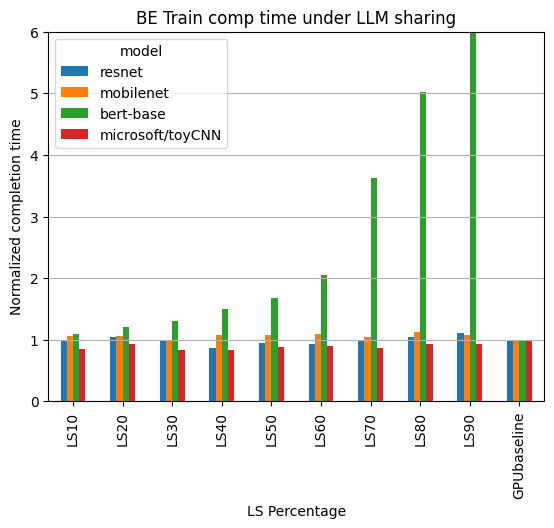

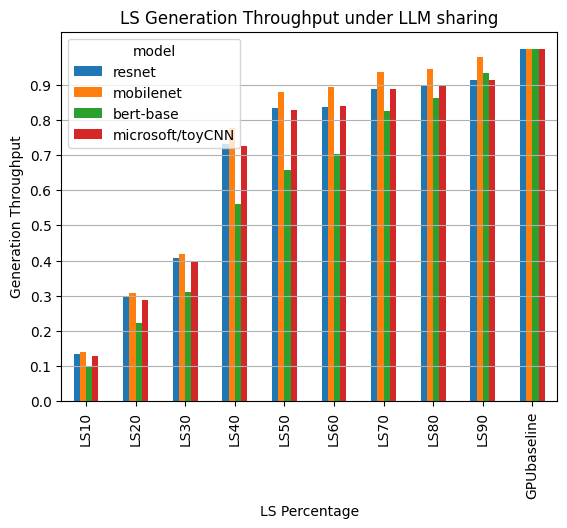

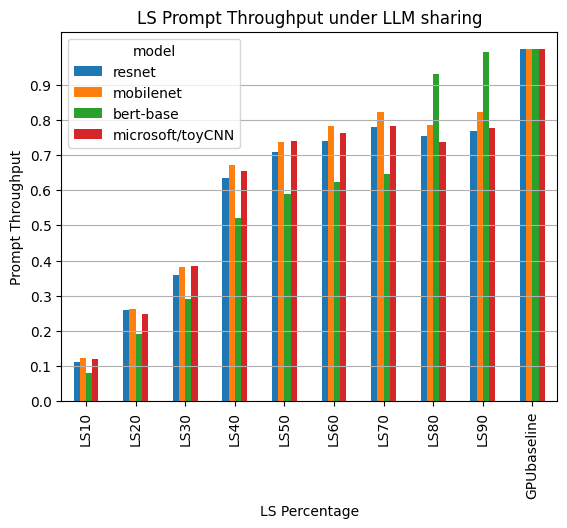

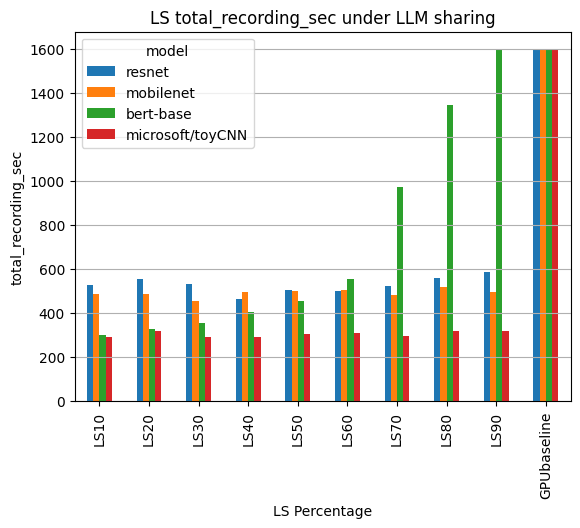

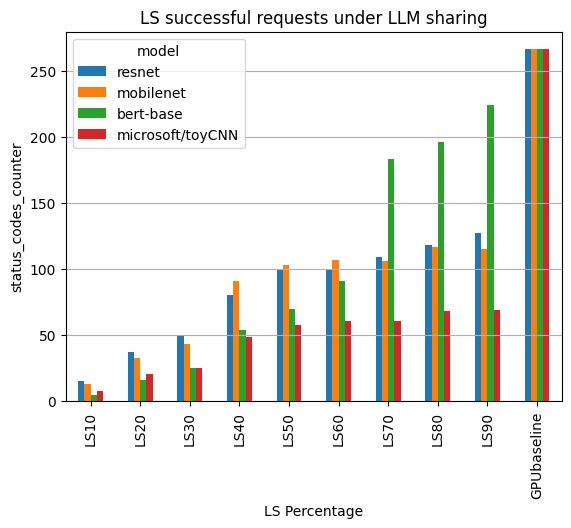

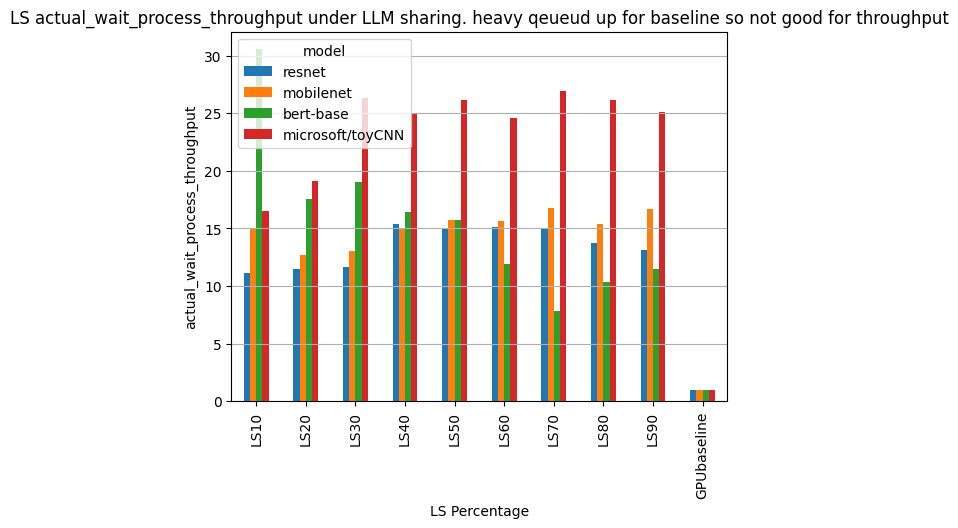

In [24]:
#plot a  BE train throughput barchart based on 'throughput_train0301.csv', with x axis = LS_percentage, y value as normalized throughput (throughput/baseline).
#each LS percentage should have multiple bars for different models
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('csv/BEthroughput_train0301.csv')
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
#df = df.drop(columns = ['baseline'])
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('Normalized completion time')
plt.title('BE Train comp time under LLM sharing')

#set finer scale on y axis
plt.yticks(np.arange(0, 11, 1))
#set grid
plt.grid(axis='y')
#set y limit
plt.ylim(0, 6)
plt.show()


# plot generation throughput with throughput normalized to baseline
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('csv/generation_throughput_trainLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('Generation Throughput')
plt.title('LS Generation Throughput under LLM sharing')
#set finer scale on y axis
plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()

df = pd.read_csv('csv/prompt_throughput_trainLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('Prompt Throughput')
plt.title('LS Prompt Throughput under LLM sharing')
#set finer scale on y axis
plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()

# total record time
df = pd.read_csv('csv/total_recording_sec_trainLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
#df = df.div(df['baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('total_recording_sec')
plt.title('LS total_recording_sec under LLM sharing')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()


df = pd.read_csv('csv/status_codes_counter_trainLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
#df = df.div(df['baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('status_codes_counter')
plt.title('LS successful requests under LLM sharing')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()

#plot actual_wait_process_throughput
df = pd.read_csv('csv/actual_wait_process_throughput_trainLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('LS Percentage')
plt.ylabel('actual_wait_process_throughput')
plt.title('LS actual_wait_process_throughput under LLM sharing. heavy qeueud up for baseline so not good for throughput')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()



In [25]:
#parse all inference logs in GPU sharing
inference_root_directory = ["/home/cc/mlProfiler/tests/mps/rtx6000_0309/sharetest/longrunCPU_1LS_1BEGPU/RUN1"]
inference_models = list(baseline_0301["inference"].keys())
#get total cpu cores

CPU_LS_percents=  [f"LS{10 * i}" for i in range(1, 11)]
throughput_dict = parse_all_BE_logs(inference_root_directory, inference_models, LS_percents, "inference", baseline_0301)

#define column = percentage of core from 10% to 90%
total_cores = len(os.sched_getaffinity(0))
core_list = [np.ceil(total_cores * 0.1 * i) for i in range(9, 0, -1)]
x = (["model"]+LS_percents)

#x.append("default")#default is without core selection
x.append("GPUbaseline")
write_BE(f'{inference_root_directory[0]}/BEthroughput_inf0301.csv', throughput_dict, inference_models, x)

#plot a  BE inference throughput barchart based on 'throughput_inf0301.csv', with x axis = LS_percentage, y value as normalized comp time (throughput/baseline).
#each LS percentage should have multiple bars for different models

#parse all LS metrics in inference
print("parsing LS metrics")
LS_infmetrics = parse_all_LS_metrics(inference_root_directory, inference_models, LS_percents, "LS_lambda0.05", baseline_0301)
#print(LS_infmetrics)
print(LS_infmetrics["facebook/wav2vec"].keys())

for col in throughput_col:
    write_LS(f'{inference_root_directory[0]}/{col}_infLS0301.csv', LS_infmetrics, inference_models, x, col)




microsoft/resnet dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
google/mobilenet dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
google/vit-base dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
facebook/wav2vec dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
bert-base-cased dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
openai/whisper-large-v2 dict_keys(['LS10', 'LS20', 'LS30', 'LS40', 'LS50', 'LS60', 'LS70', 'LS80', 'LS90', 'baseline'])
parsing LS metrics
file = /home/cc/mlProfiler/tests/mps/rtx6000_0309/sharetest/longrunCPU_1LS_1BEGPU/RUN1/LS10/imgclassification/microsoft/resnet-50/LSmetrics.csv percent = LS10 model = microsoft/resnet throughput_dict[model]={'LS10': [], 'LS20': [], 'LS30': [], 'LS40': [], 'LS50': [], 'LS60': [], 'LS70': [], 'LS80'

/home/cc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


file = /home/cc/mlProfiler/tests/mps/rtx6000_0309/sharetest/longrunCPU_1LS_1BEGPU/RUN1/LS50/imgclassification/google/mobilenet_v2_1.0_224/LSmetrics.csv percent = LS50 model = google/mobilenet throughput_dict[model]={'LS10': [{'total_recording_sec': 111, 'generation_throughput': 11.906834069041171, 'prompt_throughput': 78.69347125207544, 'generation_tokens_total': 1401.0, 'gpu_cache_usage_perc': 0.5935590763176971, 'num_requests_running': 5.0, 'num_requests_waiting': 5.0, 'requests_total_counter': 0, 'status_codes_counter': 0, 'time_per_output_token_seconds_bucket': {0.01: 0.0, 0.025: 0.0, 0.05: 0.0, 0.075: 0.0, 0.1: 0.0, 0.15: 0.0, 0.2: 44.0, 0.3: 1389.0, 0.4: 1389.0, 0.5: 1389.0, 0.75: 1389.0, 1.0: 1389.0, 2.5: 1389.0, '+inf': 1396.0}, 'time_to_first_token_seconds_bucket': {0.001: 0.0, 0.005: 0.0, 0.01: 0.0, 0.02: 0.0, 0.04: 0.0, 0.06: 0.0, 0.08: 0.0, 0.1: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 0.0, 1.0: 0.0, 2.5: 0.0, 5.0: 5.0, 7.5: 5.0, 10.0: 5.0, '+inf': 5.0}, 'time_to_first_token_seconds

/home/cc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


plotting CPU...


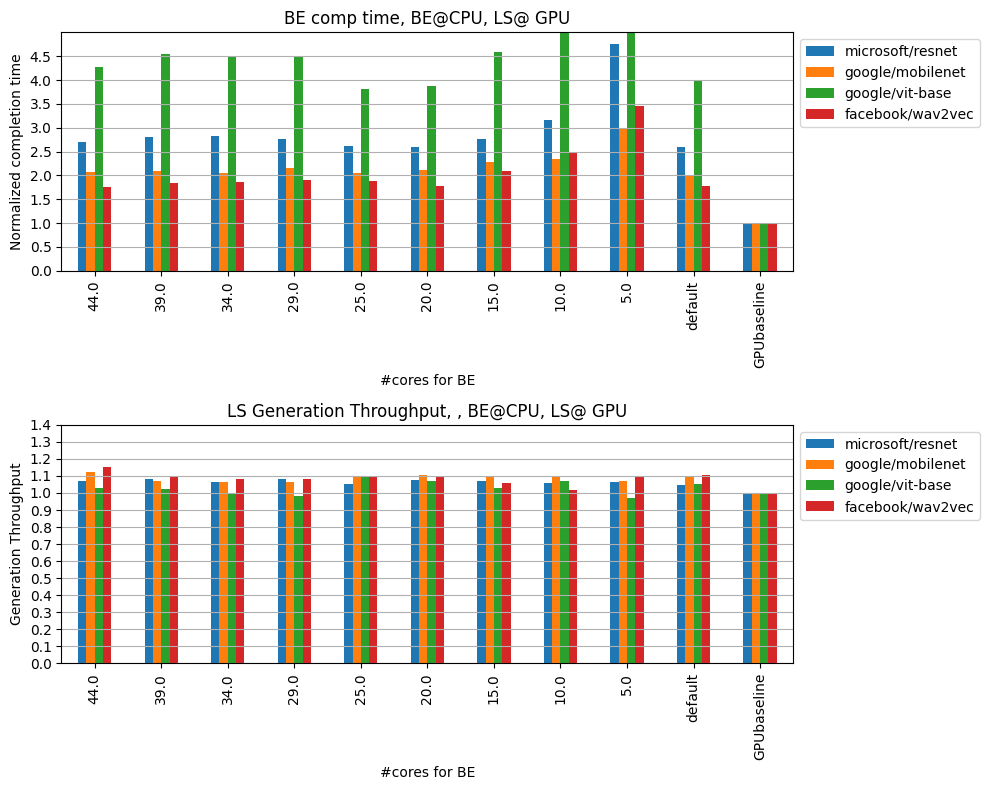

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

###Draw CPU BE throughput and LS generation throughput
print("plotting CPU...")
# Read the first CSV file
df1 = pd.read_csv('csv/CPU_BEthroughput_inf0301.csv')
df1 = df1.set_index('model')
df1 = df1.div(df1['GPUbaseline'], axis=0)
df1 = df1.T

# Read the second CSV file
df2 = pd.read_csv('csv/CPU_generation_throughput_infLS0301.csv')
df2 = df2.set_index('model')
df2 = df2.div(df2['GPUbaseline'], axis=0)
df2 = df2.T

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first DataFrame on the first subplot
df1.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('#cores for BE')
axs[0].set_ylabel('Normalized completion time')
axs[0].set_title('BE comp time, BE@CPU, LS@ GPU')
axs[0].set_yticks(np.arange(0, 5, 0.5))
axs[0].set_ylim(0, 5)
axs[0].grid(axis='y')
#smaller model legend size
axs[0].legend(fontsize='small')
#place legend outside
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot the second DataFrame on the second subplot
df2.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('#cores for BE')
axs[1].set_ylabel('Generation Throughput')
axs[1].set_title('LS Generation Throughput, , BE@CPU, LS@ GPU')
axs[1].set_yticks(np.arange(0, 1.5, 0.1))
axs[1].grid(axis='y')
#smaller model legend size
axs[1].legend(fontsize='small')
#place legend outside
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

plotting GPU sharing...


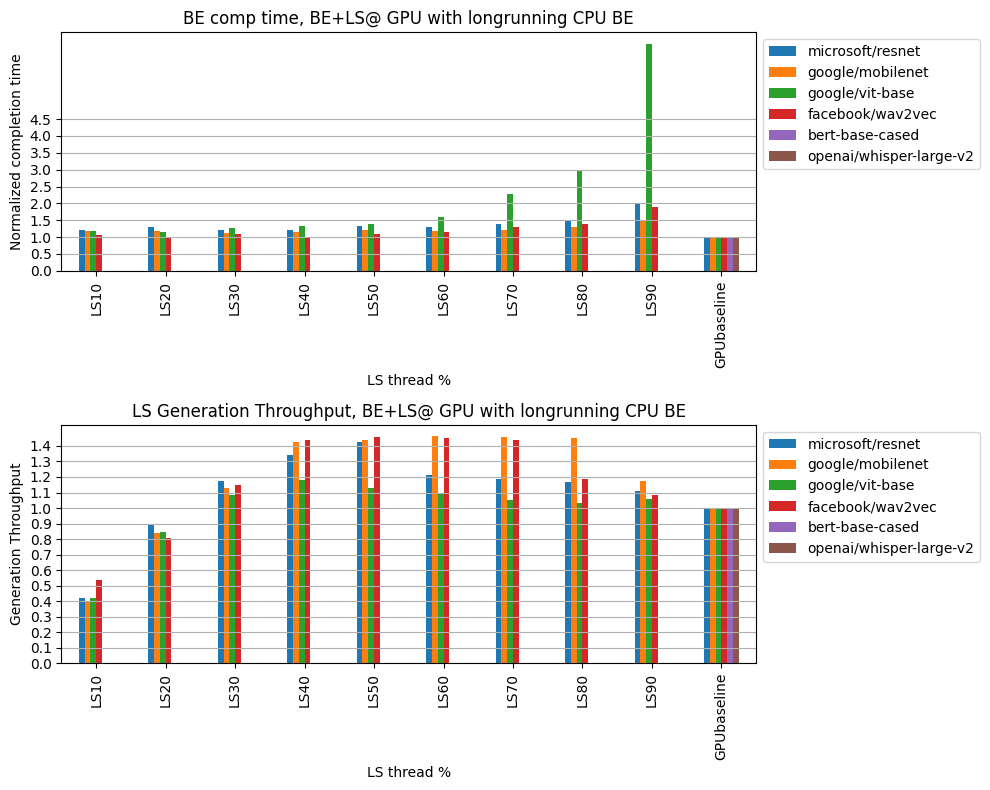

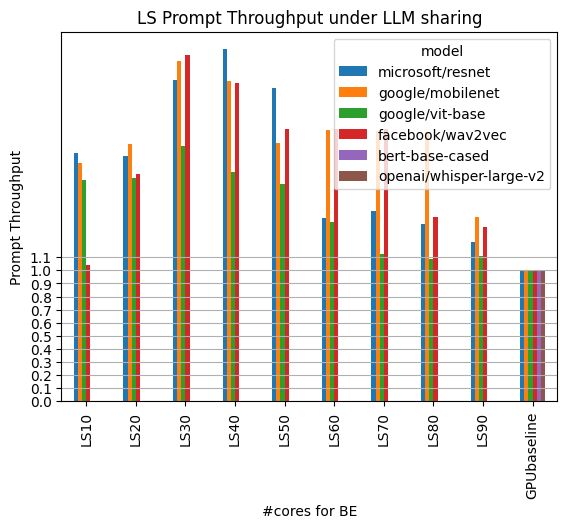

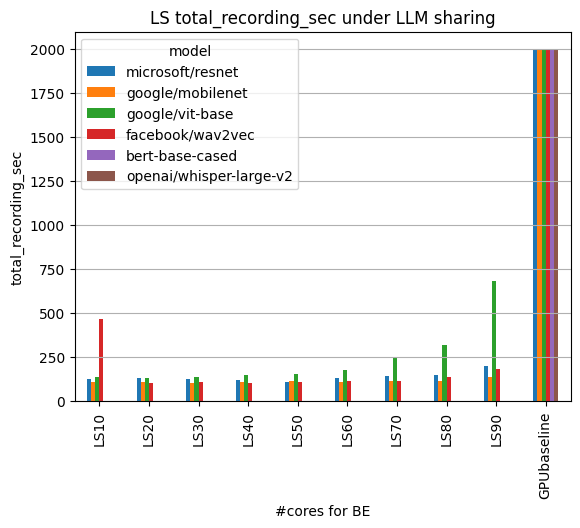

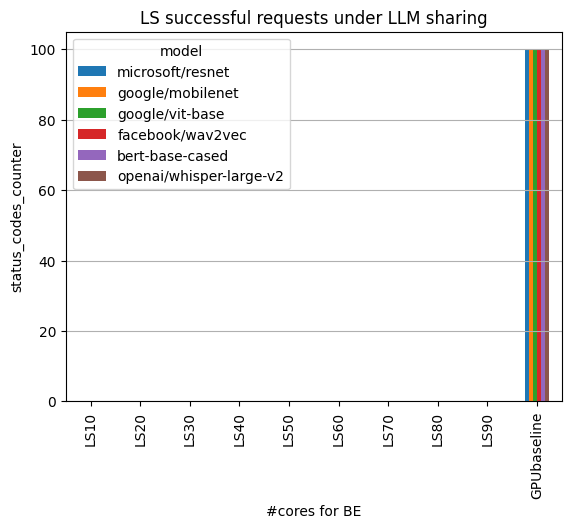

"\ndf = pd.read_csv('csv/actual_wait_process_throughput_infLS0301.csv')\n#throughput normalized to baseline\ndf = df.set_index('model')\ndf = df.div(df['GPUbaseline'], axis=0)\ndf = df.T\ndf.plot(kind='bar')\nplt.xlabel('#cores for BE')\nplt.ylabel('actual_wait_process_throughput')\nplt.title('LS actual_wait_process_throughput under LLM sharing.  baseline has no queued up reflects output')\n#set finer scale on y axis\n#plt.yticks(np.arange(0, 1, 0.1))\n#set grid\nplt.grid(axis='y')\nplt.show()\n"

In [32]:



print("plotting GPU sharing...")


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the first CSV file
df3 = pd.read_csv(f'{inference_root_directory[0]}/BEthroughput_inf0301.csv')
df3 = df3.set_index('model')
df3 = df3.div(df3['GPUbaseline'], axis=0)
df3 = df3.T

# Read the second CSV file
df4 = pd.read_csv(f'{inference_root_directory[0]}/generation_throughput_infLS0301.csv')
df4 = df4.set_index('model')
df4 = df4.div(df4['GPUbaseline'], axis=0)
df4 = df4.T

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first DataFrame on the first subplot
df3.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('LS thread %')
axs[0].set_ylabel('Normalized completion time')
axs[0].set_title('BE comp time, BE+LS@ GPU with longrunning CPU BE')
axs[0].set_yticks(np.arange(0, 5, 0.5))
axs[0].grid(axis='y')
axs[0].legend(fontsize='small')
#place legend outside
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot the second DataFrame on the second subplot
df4.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('LS thread %')
axs[1].set_ylabel('Generation Throughput')
axs[1].set_title('LS Generation Throughput, BE+LS@ GPU with longrunning CPU BE')
axs[1].set_yticks(np.arange(0, 1.5, 0.1))
axs[1].grid(axis='y')
axs[1].legend(fontsize='small')
#place legend outside
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()




# plot prompt throughput with throughput normalized to baseline
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f'{inference_root_directory[0]}/prompt_throughput_infLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('#cores for BE')
plt.ylabel('Prompt Throughput')
plt.title('LS Prompt Throughput under LLM sharing')
#set finer scale on y axis
plt.yticks(np.arange(0, 1.2, 0.1))
#set grid
plt.grid(axis='y')
plt.show()


# total record time
df = pd.read_csv(f'{inference_root_directory[0]}/total_recording_sec_infLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
#df = df.div(df['baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('#cores for BE')
plt.ylabel('total_recording_sec')
plt.title('LS total_recording_sec under LLM sharing')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()


df = pd.read_csv(f'{inference_root_directory[0]}/status_codes_counter_infLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
#df = df.div(df['baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('#cores for BE')
plt.ylabel('status_codes_counter')
plt.title('LS successful requests under LLM sharing')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()

#plot actual_wait_process_throughput
"""
df = pd.read_csv('csv/actual_wait_process_throughput_infLS0301.csv')
#throughput normalized to baseline
df = df.set_index('model')
df = df.div(df['GPUbaseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('#cores for BE')
plt.ylabel('actual_wait_process_throughput')
plt.title('LS actual_wait_process_throughput under LLM sharing.  baseline has no queued up reflects output')
#set finer scale on y axis
#plt.yticks(np.arange(0, 1, 0.1))
#set grid
plt.grid(axis='y')
plt.show()
"""





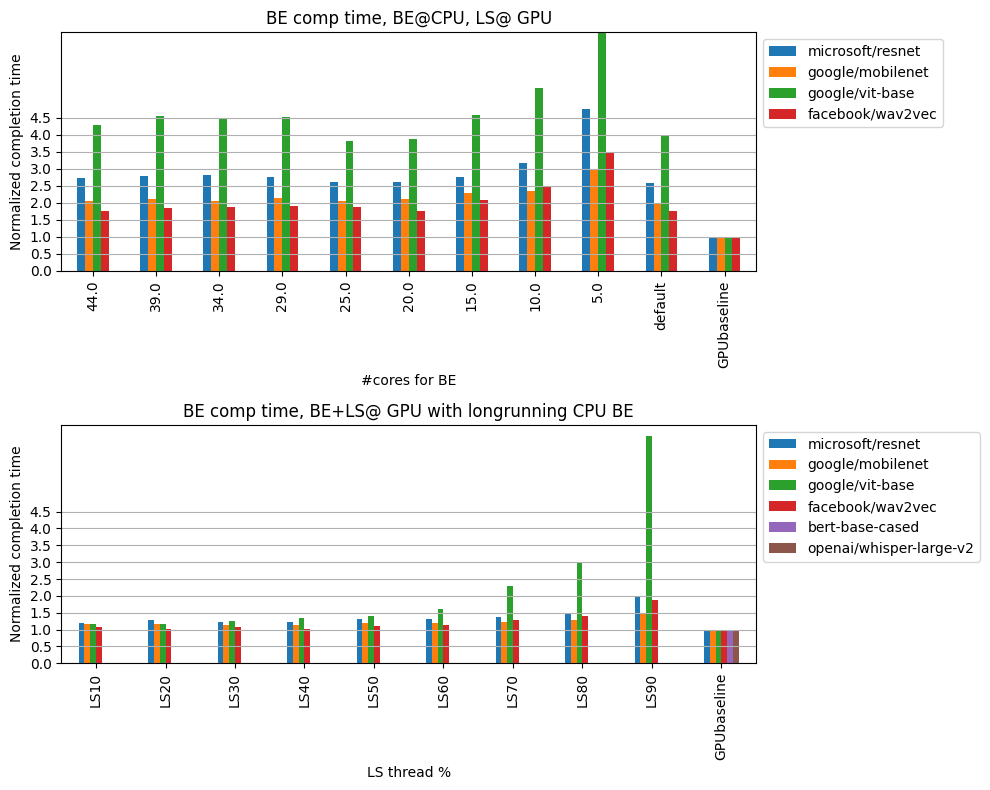

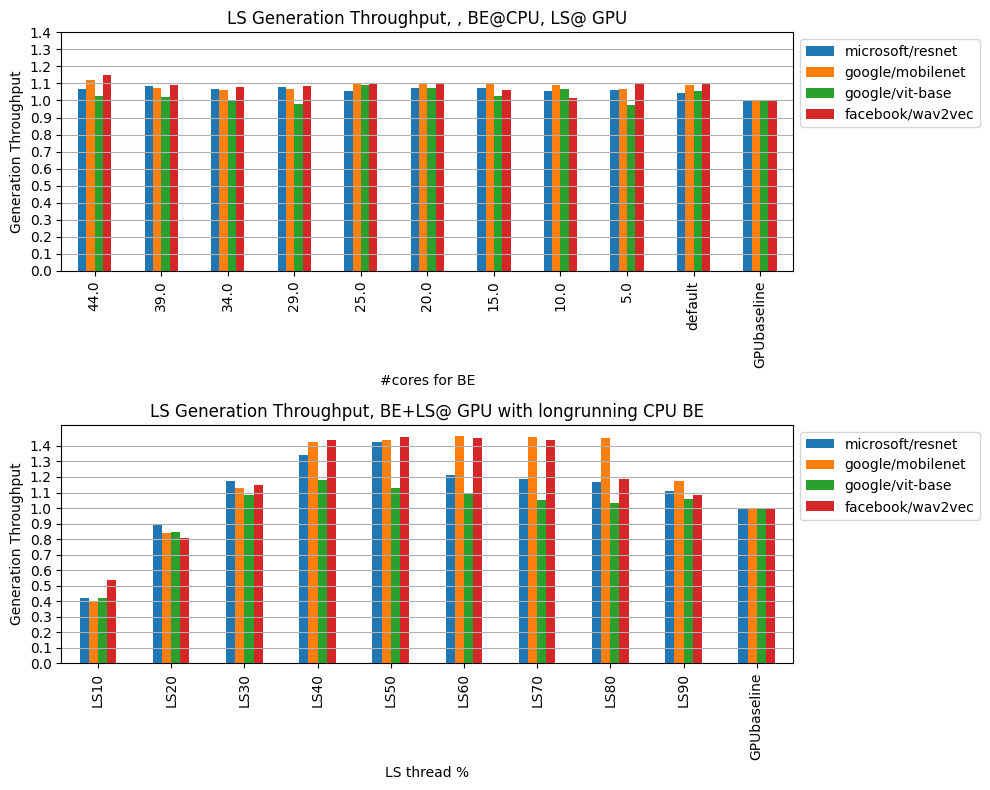

In [28]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first DataFrame on the first subplot
df1.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('#cores for BE')
axs[0].set_ylabel('Normalized completion time')
axs[0].set_title('BE comp time, BE@CPU, LS@ GPU')
axs[0].set_yticks(np.arange(0, 5, 0.5))
axs[0].set_ylim(0, 7)
axs[0].grid(axis='y')
#smaller model legend size
axs[0].legend(fontsize='small')
#place legend outside
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot the first DataFrame on the first subplot
df3.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('LS thread %')
axs[1].set_ylabel('Normalized completion time')
axs[1].set_title('BE comp time, BE+LS@ GPU with longrunning CPU BE')
axs[1].set_yticks(np.arange(0, 5, 0.5))
axs[1].grid(axis='y')
axs[1].legend(fontsize='small')
#place legend outside
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()




# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first DataFrame on the first subplot
# Plot the second DataFrame on the second subplot
df2.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('#cores for BE')
axs[0].set_ylabel('Generation Throughput')
axs[0].set_title('LS Generation Throughput, , BE@CPU, LS@ GPU')
axs[0].set_yticks(np.arange(0, 1.5, 0.1))
axs[0].grid(axis='y')
#smaller model legend size
axs[0].legend(fontsize='small')
#place legend outside
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot the second DataFrame on the second subplot
df4.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('LS thread %')
axs[1].set_ylabel('Generation Throughput')

axs[1].set_title('LS Generation Throughput, BE+LS@ GPU with longrunning CPU BE')
axs[1].set_yticks(np.arange(0, 1.5, 0.1))
axs[1].grid(axis='y')
axs[1].legend(fontsize='small')
#place legend outside
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()
plt.show()

/home/cc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


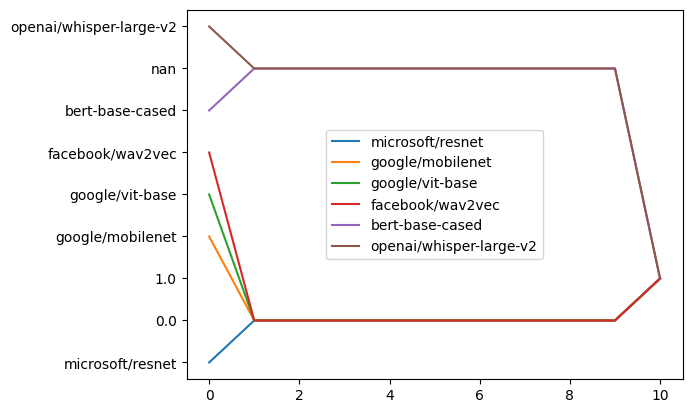

In [29]:
def plot_request_per_second(filename, data, models, time_col, req_col):
    for model in models:
        row = [model]
        for percent in LS_percents:
            time_column = [single_file_metric[time_col] for single_file_metric in data[model][percent]]
            req_column = [single_file_metric[req_col] for single_file_metric in data[model][percent]]
            row.append(np.mean(req_column)/np.mean(time_column))#average of each run

        
        baseline_time_column = [single_file_metric[time_col] for single_file_metric in data[model]["baseline"]]
        baseline_req_column = [single_file_metric[time_col] for single_file_metric in data[model]["baseline"]]
        row.append(np.mean(baseline_req_column)/np.mean( baseline_time_column))
        plt.plot(row, label=model)
    plt.legend()
    plt.show()

plot_request_per_second("", LS_infmetrics, inference_models, "total_recording_sec", "status_codes_counter")

defaultdict(<class 'dict'>, {'microsoft/resnet': {'batch1': [503.9442], 'batch2': [415.0745], 'batch4': [334.8297], 'batch8': [293.3769], 'batch16': [375.7298], 'batch32': [439.6791], 'batch64': [488.8329], 'baseline': [97.2]}, 'google/mobilenet': {'batch1': [443.5187], 'batch2': [343.1445], 'batch4': [282.2263], 'batch8': [312.7644], 'batch16': [250.587], 'batch32': [325.222], 'batch64': [346.9924], 'baseline': [88.36]}, 'google/vit-base': {'batch1': [671.1208], 'batch2': [607.414], 'batch4': [592.4912], 'batch8': [509.0443], 'batch16': [524.5172], 'batch32': [570.8003], 'batch64': [716.537], 'baseline': [105]}, 'facebook/wav2vec': {'batch1': [171.9469], 'batch2': [209.821], 'batch4': [252.8731], 'batch8': [298.066], 'batch16': [365.3325], 'batch32': [412.8575], 'batch64': [491.4724], 'baseline': [94.2]}, 'bert-base-cased': {'batch1': [], 'batch2': [], 'batch4': [], 'batch8': [], 'batch16': [], 'batch32': [], 'batch64': [], 'baseline': [323]}, 'openai/whisper-large-v2': {'batch1': [],

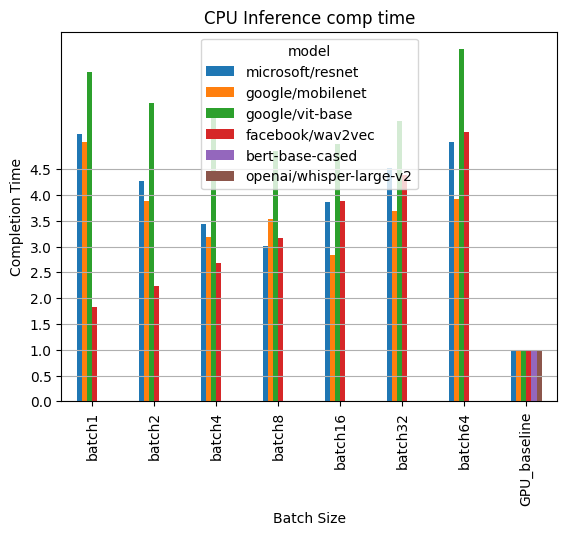

In [30]:
# Baseline GPU/CPU comparison on inference BE jobs - check if there is any difference in the throughput of the jobs
batches = [1, 2, 4, 8, 16, 32, 64]
baseline_inf_root_directory = ['/home/cc/mlProfiler/tests/mps/rtx6000_logs/baseline/inference']

def parse_all_CPU_logs(root_directory, models, batches, type):
    #init throughput dict
    throughput_dict = defaultdict(dict)
    for model in models:
        throughput_dict[model] = {}
        for percent in batches:
            throughput_dict[model][f"batch{percent}"] = []
        throughput_dict[model]["baseline"] = []

    #choose parse log based on types
    parse_logs = parse_train_log_file if type == "training" else parse_inference_log_file
    for root_dir in root_directory:
        for model in models:
            for percent in batches:
                for file in get_subdirectories(root_dir, ".log"):
                    
                    if f"batch{percent}.log" in file and model in file and type in file:
                        #if model == "facebook/wav2vec":
                        #    print(f"file={file}")
                        throughput_dict[model][f"batch{percent}"].append(parse_logs(file))
            throughput_dict[model]["baseline"].append(baseline_0301["inference"][model])  
    print(throughput_dict)
    return throughput_dict

cpu_dict = parse_all_CPU_logs(baseline_inf_root_directory, inference_models, batches, "cpu")
cpu_dict["facebook/wav2vec"]
#write cpu dict to csv
import csv
def write_cpu(filename, data, models):
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["model", "batch1", "batch2", "batch4", "batch8", "batch16", "batch32", "batch64", "GPU_baseline"])
        for model in models:
            row = [model]
            for percent in batches:
                if len(data[model][f"batch{percent}"]) == 0 or data[model][f"batch{percent}"] == [None]:
                    row.append(0)
                else:
                    print(f"model={model} percent={percent} data={data[model][f'batch{percent}']}")
                    row.append(np.mean(data[model][f"batch{percent}"]))
            row.append(np.mean(data[model]["baseline"]))
            writer.writerow(row)
write_cpu('cpu_throughput_inf.csv', cpu_dict, inference_models)

#plot cpu_throughput_inf.csv
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('cpu_throughput_inf.csv')
df = df.set_index('model')
#normalize with GPU_baseline
df = df.div(df['GPU_baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('Batch Size')
plt.ylabel('Completion Time')
plt.title('CPU Inference comp time')
#set finer scale on y axis
plt.yticks(np.arange(0, 5, 0.5))
#set grid
plt.grid(axis='y')
plt.show()







defaultdict(<class 'dict'>, {'microsoft/resnet': {'batch1': [283.304], 'batch2': [237.7939], 'batch4': [203.1801], 'batch8': [187.5343], 'batch16': [169.4533], 'batch32': [175.3628], 'batch64': [172.5082], 'baseline': [97.2]}, 'google/mobilenet': {'batch1': [282.0708], 'batch2': [233.3348], 'batch4': [205.4558], 'batch8': [185.7781], 'batch16': [177.7325], 'batch32': [163.3133], 'batch64': [165.9889], 'baseline': [88.36]}, 'google/vit-base': {'batch1': [273.8763], 'batch2': [203.5999], 'batch4': [189.6125], 'batch8': [177.2431], 'batch16': [173.5992], 'batch32': [176.3411], 'batch64': [174.1876], 'baseline': [105]}, 'facebook/wav2vec': {'batch1': [101.0796], 'batch2': [102.5727], 'batch4': [103.5339], 'batch8': [104.2654], 'batch16': [108.0088], 'batch32': [114.1754], 'batch64': [None], 'baseline': [94.2]}, 'bert-base-cased': {'batch1': [], 'batch2': [], 'batch4': [], 'batch8': [], 'batch16': [], 'batch32': [], 'batch64': [], 'baseline': [323]}, 'openai/whisper-large-v2': {'batch1': []

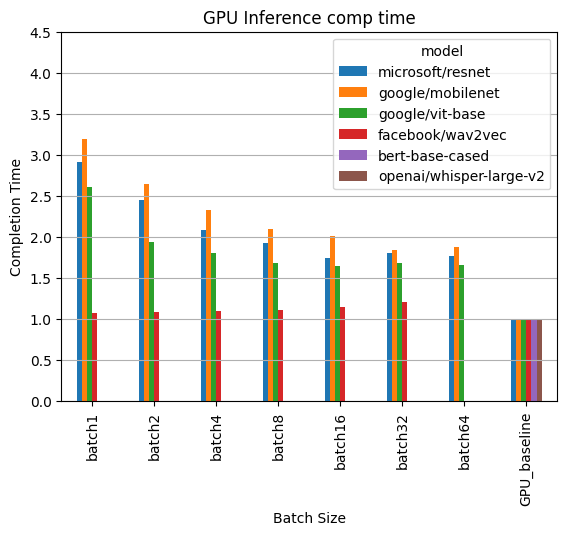

In [31]:
gpu_dict = parse_all_CPU_logs(baseline_inf_root_directory, inference_models, batches, "cuda")
write_cpu('gpu_throughput_batch_inf.csv', gpu_dict, inference_models)

#plot gpu_throughput_batch_inf.csv
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('gpu_throughput_batch_inf.csv')
df = df.set_index('model')
#normalize with GPU_baseline
df = df.div(df['GPU_baseline'], axis=0)
df = df.T
df.plot(kind='bar')
plt.xlabel('Batch Size')
plt.ylabel('Completion Time')
plt.title('GPU Inference comp time')
#set finer scale on y axis
plt.yticks(np.arange(0, 5, 0.5))
#set grid
plt.grid(axis='y')
plt.show()

In [5]:
import pandas as pd

# Load the baseline labels CSV file
df = pd.read_csv("baseline_labels.csv")

# Create a dictionary to store Type and memcap values
type_dict = {}
n_comb = 4  # Number of combinations
GPUCAP = 32  # GPU capacity

# Populate type_dict with Type and memcap values
for index, row in df.iterrows():
    type_dict[row["Type"]] = float(row["memcap"])
print(type_dict)
# Read the combination CSV file
combdf = pd.read_csv("../multiinstance/filtered_batch4_kernel_labels.csv")

oom_idx = []  # List to store indices of rows that exceed GPU capacity

# Iterate over each row in combdf and calculate sum_memcap
for index, row in combdf.iterrows():
    sum_memcap = 0
    for i in range(1, n_comb + 1):
        print(type_dict[row[f"workload{i}"]])
        sum_memcap += type_dict[row[f"workload{i}"]]
    
    # Check if the sum_memcap exceeds GPUCAP
    if sum_memcap > GPUCAP:
        oom_idx.append(index)

# Print number of rows that exceed GPU capacity
print(f"Number of rows exceeding GPU capacity: {len(oom_idx)}")
print(f"Total number of rows: {len(combdf)}")

# Drop rows that exceed GPU capacity and write the remaining rows to a new CSV
combdf = combdf.drop(oom_idx)
combdf.to_csv("../multiinstance/exclude_oom_kernel_labels_comb4_fixedbatch4_with_batches2-8.csv", index=False)


{'whisper-large-v2_batch16-inf': 15.4, 'whisper-large-v2_batch8-inf': 11.4, 'whisper-large-v2_batch2-inf': 8.3, 'bert-base-cased_batch16-inf': 1.6, 'resnet-50_batch8-inf': 2.5, 'resnet-50_batch2-inf': 1.3, 'resnet-50_batch16-inf': 3.9, 'bert-base-cased_batch8-inf': 1.4, 'mobilenet_v2_1.0_224_batch2-inf': 1.2, 'vit-base-patch16-224_batch8-inf': 3.1, 'mobilenet_v2_1.0_224_batch8-inf': 2.2, 'vit-base-patch16-224_batch2-inf': 1.6, 'vit-base-patch16-224_batch16-inf': 5.1, 'mobilenet_v2_1.0_224_batch16-inf': 3.6, 'wav2vec2-base-960h_batch2-inf': 3.9, 'wav2vec2-base-960h_batch16-inf': 21.5, 'wav2vec2-base-960h_batch8-inf': 11.4, 'bert-base-cased_batch2-inf': 1.2, 'vit_h_14_batch8-train': 17.4, 'mobilenet_batch16-train': 1.2, 'vit_h_14_batch16-train': 21.2, 'resnet-50_batch16-train': 2.8, 'bert-base-cased_batch16-train': 7.4, 'mobilenet_batch2-train': 1.2, 'resnet-50_batch2-train': 1.5, 'bert-base-cased_batch8-train': 4.9, 'vit_h_14_batch2-train': 14.3, 'albert-base-v2_batch2-train': 2.3, 'alb

OSError: Cannot save file into a non-existent directory: '/home/cc/mlProfiler/tests/mps/multiinstance'